Eric Lisboa Queiroz

Parte A: ANÁLISE DO SINAL DO MOTOR

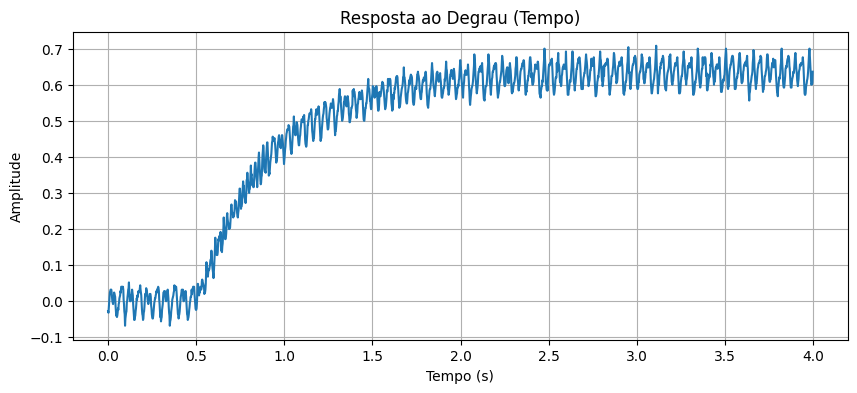

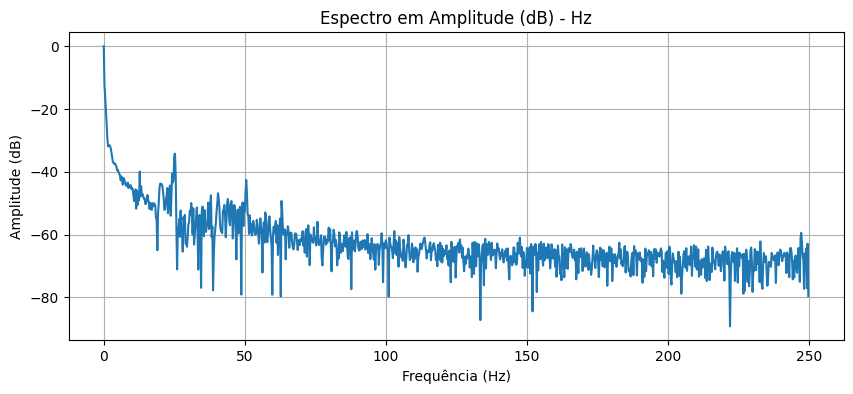

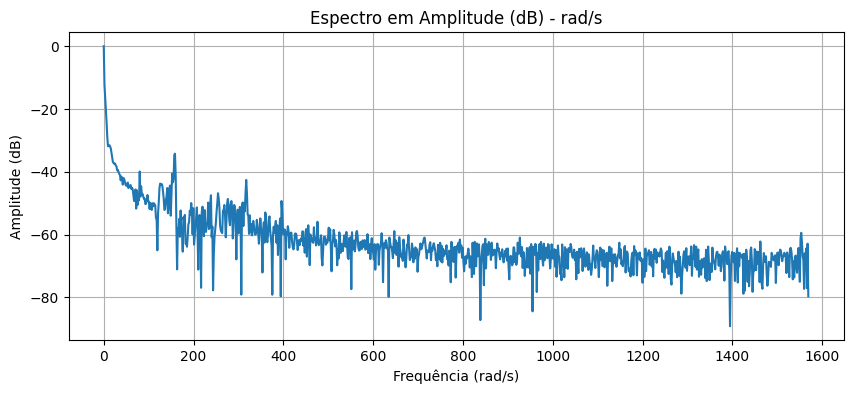

Análise concluída: tempo, espectro em Hz e espectro em rad/s.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.fft import fft, fftfreq

# ---------------------------------------------------------
# 1) Carregar o arquivo .mat
# ---------------------------------------------------------
dados = scipy.io.loadmat("motor.mat")
v = dados['v'].flatten()
fs = 500  # Hz

N = len(v)
t = np.arange(N) / fs

# ---------------------------------------------------------
# 2) Gráfico temporal da resposta ao degrau
# ---------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(t, v)
plt.title('Resposta ao Degrau (Tempo)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 3) Espectro em Hz (sem janelamento)
# ---------------------------------------------------------
V = fft(v)
freqs = fftfreq(N, 1/fs)

# Apenas metade positiva
pos_mask = freqs >= 0
freqs_pos = freqs[pos_mask]
V_pos = np.abs(V[pos_mask])

# Converter para dB
V_db = 20*np.log10(V_pos / np.max(V_pos))

plt.figure(figsize=(10,4))
plt.plot(freqs_pos, V_db)
plt.title('Espectro em Amplitude (dB) - Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 4) Espectro em rad/s
# ---------------------------------------------------------
w = 2*np.pi * freqs_pos  # rad/s

plt.figure(figsize=(10,4))
plt.plot(w, V_db)
plt.title('Espectro em Amplitude (dB) - rad/s')
plt.xlabel('Frequência (rad/s)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.show()

print("Análise concluída: tempo, espectro em Hz e espectro em rad/s.")


Parte B: DEFINIÇÃO DAS ESPECIFICAÇÕES DE FILTRAGEM

Definir bandas e diagramas de tolerância

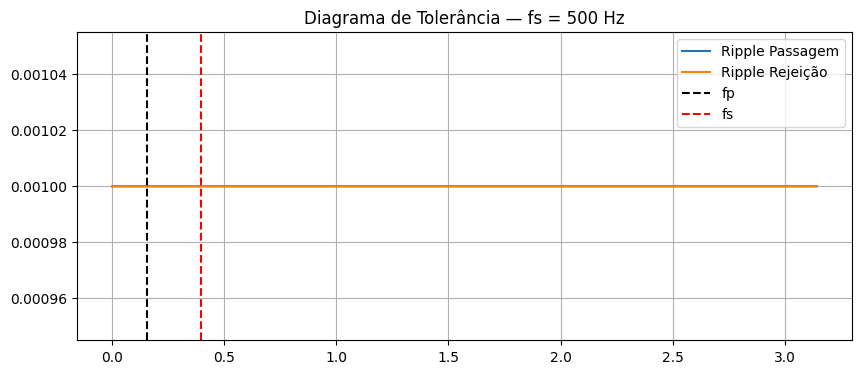

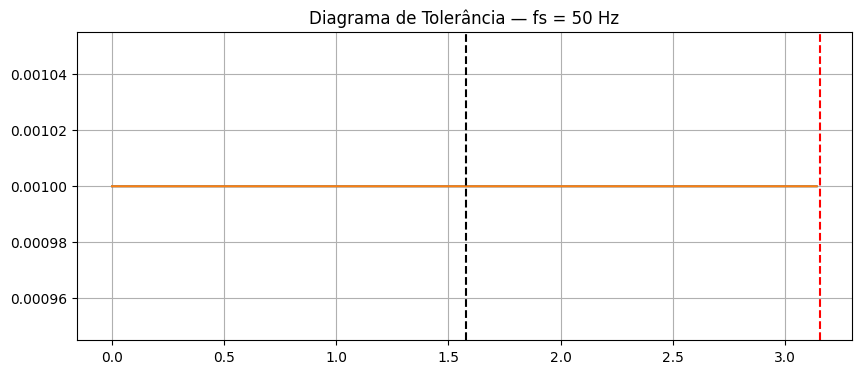

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Especificações
fs1 = 500
fs2 = 50

# Banda útil real
fp = 4     # Hz
fsb = 10   # Hz para fs=500
fsb2 = 8   # Hz para fs=50

Ap = 0.001   # ripple de passagem
As = 0.001   # ripple de rejeição

# Diagramas
w = np.linspace(0, np.pi, 2000)

plt.figure(figsize=(10,4))
plt.plot(w, np.ones_like(w)*Ap, label='Ripple Passagem')
plt.plot(w, np.ones_like(w)*As, label='Ripple Rejeição')
plt.axvline(2*np.pi*fp/fs1*np.pi, color='k', linestyle='--', label='fp')
plt.axvline(2*np.pi*fsb/fs1*np.pi, color='r', linestyle='--', label='fs')
plt.title("Diagrama de Tolerância — fs = 500 Hz")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(w, np.ones_like(w)*Ap)
plt.plot(w, np.ones_like(w)*As)
plt.axvline(2*np.pi*fp/fs2*np.pi, color='k', linestyle='--')
plt.axvline(2*np.pi*fsb2/fs2*np.pi, color='r', linestyle='--')
plt.title("Diagrama de Tolerância — fs = 50 Hz")
plt.grid()
plt.show()


Parte C: SÍNTESE DOS FILTROS FIR (Janela de Kaiser)

Projetar os filtros FIR com Kaiser

In [ ]:
from scipy.signal import kaiserord, firwin

# Filtro fs = 500 Hz
transition_bw1 = (10 - 4) / fs1
N1, beta1 = kaiserord(60, transition_bw1)

h1 = firwin(N1+1, 4/(fs1/2), window=('kaiser', beta1))

# Filtro fs = 50 Hz
transition_bw2 = (8 - 4) / fs2
N2, beta2 = kaiserord(60, transition_bw2)

h2 = firwin(N2+1, 4/(fs2/2), window=('kaiser', beta2))

print("Ordem filtro (fs=500 Hz):", N1)
print("Ordem filtro (fs=50 Hz):", N2)
print("Beta fs=500:", beta1, "  Beta fs=50:", beta2)


Ordem filtro (fs=500 Hz): 606
Ordem filtro (fs=50 Hz): 92
Beta fs=500: 5.65326   Beta fs=50: 5.65326


Parte D: APLICAÇÃO DOS FILTROS

In [ ]:
from scipy.signal import lfilter, decimate

# Dados originais
v = dados["v"].flatten()
fs = 500

# Decimação
vd = decimate(v, 10)
fsd = fs / 10

# Convolução
y_conv_500 = np.convolve(v, h1, mode='same')
y_lf_500 = lfilter(h1, 1, v)

# 50 Hz
y_conv_50 = np.convolve(vd, h2, mode='same')
y_lf_50 = lfilter(h2, 1, vd)

# Atraso = metade da ordem
delay_500 = N1 // 2
delay_50 = N2 // 2

print("Atraso fs=500 Hz:", delay_500, "amostras")
print("Atraso fs=50 Hz:", delay_50, "amostras")

Atraso fs=500 Hz: 303 amostras
Atraso fs=50 Hz: 46 amostras


Gráficos comparativos

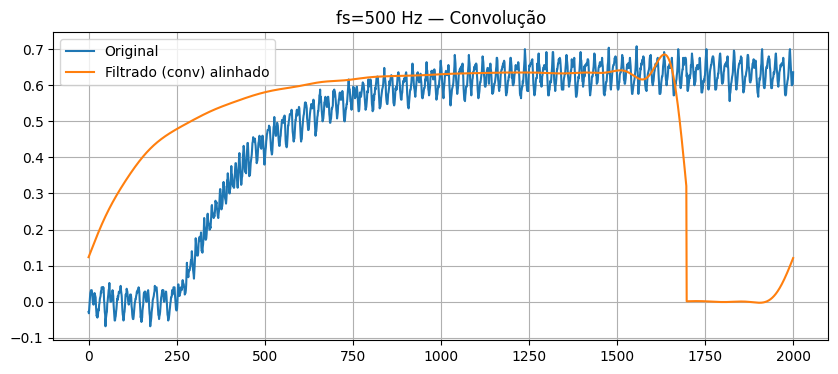

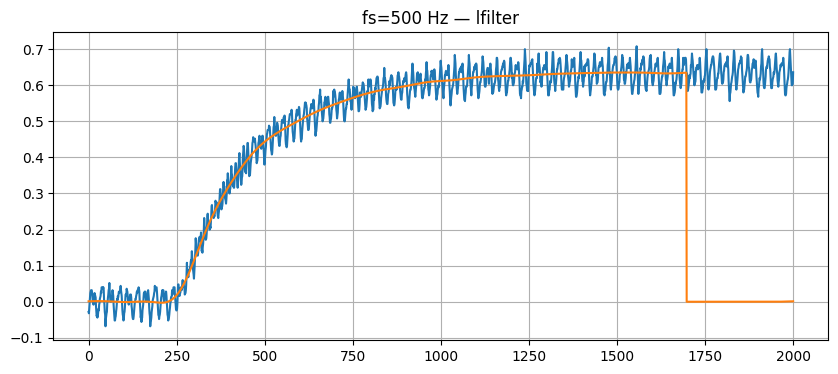

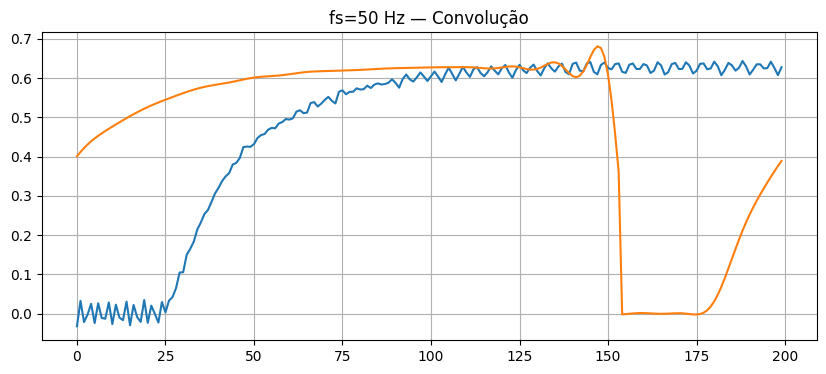

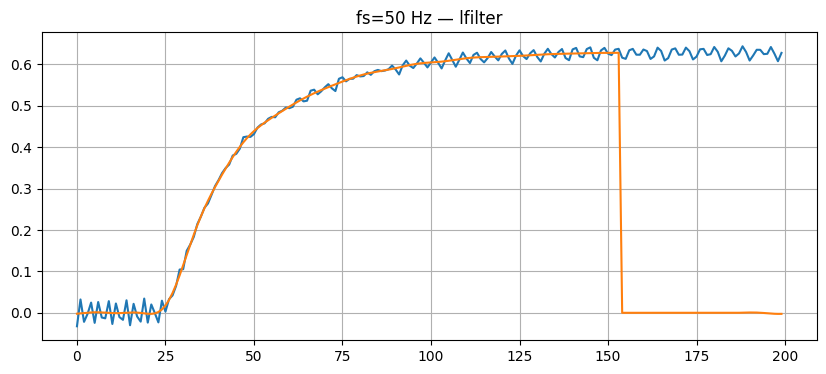

In [ ]:
# FS 500 — convolução
plt.figure(figsize=(10,4))
plt.plot(v, label="Original")
plt.plot(np.roll(y_conv_500, -delay_500), label="Filtrado (conv) alinhado")
plt.title("fs=500 Hz — Convolução")
plt.legend()
plt.grid()
plt.show()

# FS 500 — lfilter
plt.figure(figsize=(10,4))
plt.plot(v)
plt.plot(np.roll(y_lf_500, -delay_500))
plt.title("fs=500 Hz — lfilter")
plt.grid()
plt.show()

# FS 50 — convolução
plt.figure(figsize=(10,4))
plt.plot(vd)
plt.plot(np.roll(y_conv_50, -delay_50))
plt.title("fs=50 Hz — Convolução")
plt.grid()
plt.show()

# FS 50 — lfilter
plt.figure(figsize=(10,4))
plt.plot(vd)
plt.plot(np.roll(y_lf_50, -delay_50))
plt.title("fs=50 Hz — lfilter")
plt.grid()
plt.show()


Parte E: FILTRAGEM COM MÉDIA MÓVEL

Zeros para M=7 (fs=50 Hz): [ 6.25 12.5  18.75 25.   31.25 37.5  43.75]
Zeros do MM M=7 com fs=50 Hz: [ 6.25 12.5  18.75 25.   31.25 37.5  43.75]
Possível M para zero em 20 Hz: 24
Possível M para zero em 80 Hz: 5


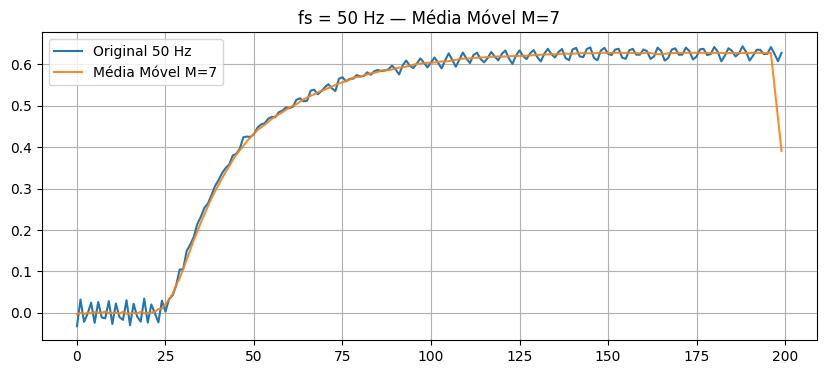

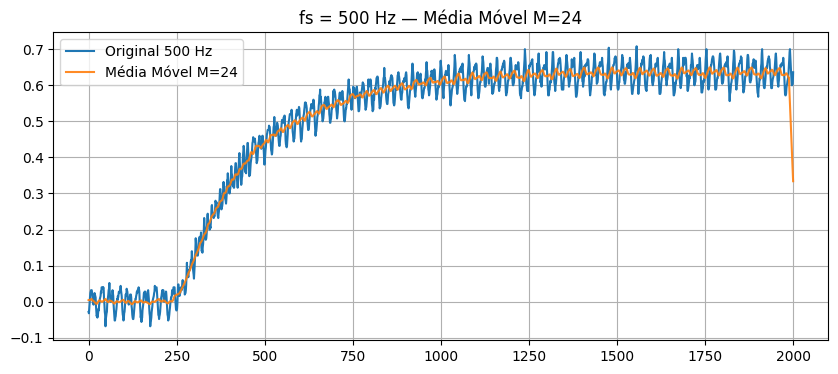

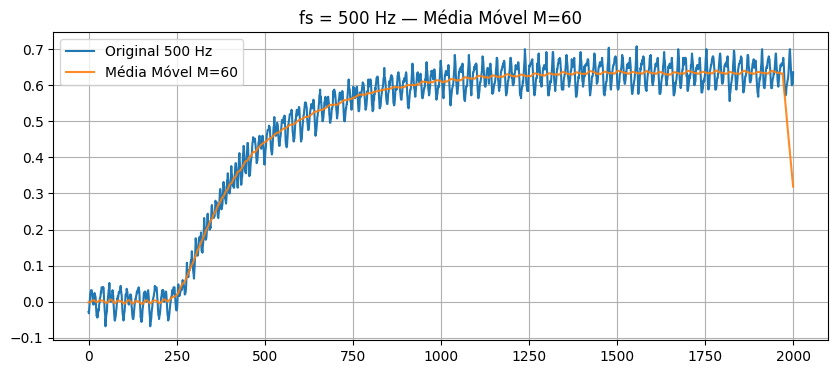

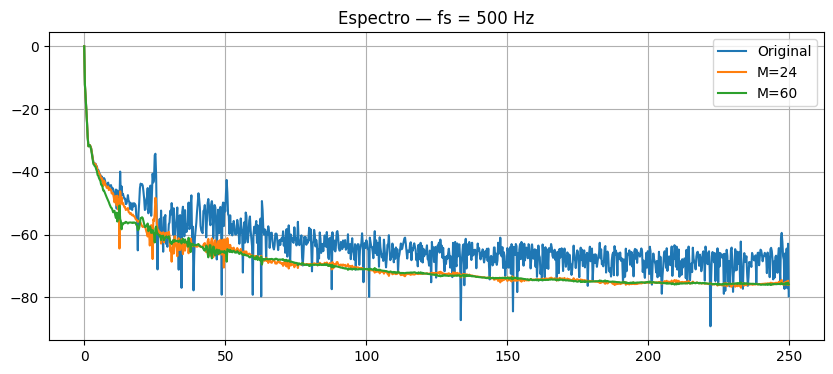

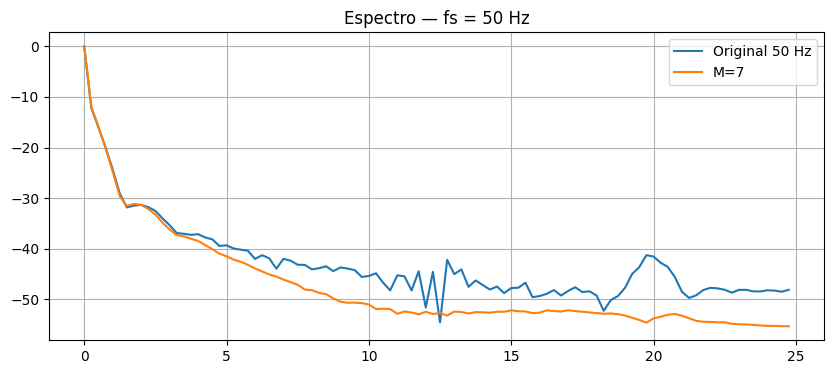

=== Parte E executada com sucesso! ===


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import decimate, lfilter, freqz
from scipy.fft import fft, fftfreq

# ============================================================
# === CARREGAR ARQUIVO (FAZER UPLOAD DO motor.mat NO COLAB) ===
# ============================================================
dados = scipy.io.loadmat("motor.mat")
v = dados['v'].flatten()
fs = 500

# ============================================================
# === PARTE E.1 – ZEROS DA MÉDIA MÓVEL ========================
# ============================================================

def zeros_moving_average(M, fs):
    """
    Retorna as frequências (Hz) onde a média móvel de ordem M
    tem magnitude nula.
    """
    k = np.arange(1, M+1)
    fk = (k/(M+1))*fs
    return fk

# Exemplo:
print("Zeros para M=7 (fs=50 Hz):", zeros_moving_average(7, 50))

# ============================================================
# === PARTE E.2 – TESTAR M=7 PARA FS=50 Hz ====================
# ============================================================

vd = decimate(v, 10)  # decimado
fsd = fs/10

# Frequências dos zeros
zeros_M7_50 = zeros_moving_average(7, fsd)
print("Zeros do MM M=7 com fs=50 Hz:", zeros_M7_50)

# ============================================================
# === PARTE E.3 – ESTIMAR M PARA FS=500 Hz ===================
# ============================================================

# alvo: ruído entre ~20 e 80 Hz
target1 = 20
target2 = 80

M_est1 = int(fs/target1) - 1  # zero em 20 Hz
M_est2 = int(fs/target2) - 1  # zero em 80 Hz

print("Possível M para zero em 20 Hz:", M_est1)
print("Possível M para zero em 80 Hz:", M_est2)

# ============================================================
# === PARTE E.4 – APLICAR FILTROS DE MEDIA MÓVEL ==============
# ============================================================

def moving_average_filter(x, M):
    h = np.ones(M+1)/(M+1)
    y = np.convolve(x, h, mode='same')
    return y, h

# M=7 para fs=50 Hz
y_M7_50, h_M7 = moving_average_filter(vd, 7)

# M estimado para fs=500 Hz (exemplo M=24)
M24 = 24
y_M24_500, h_M24 = moving_average_filter(v, M24)

# ============================================================
# === PARTE E.5 – TESTAR M=60 =================================
# ============================================================

y_M60_500, h_M60 = moving_average_filter(v, 60)

# ============================================================
# === ESPECTROS PARA COMPARAÇÃO ===============================
# ============================================================

def spectrum(x, fs):
    N = len(x)
    freqs = fftfreq(N, 1/fs)
    X = fft(x)
    mask = freqs >= 0
    freqs = freqs[mask]
    mag_db = 20*np.log10(np.abs(X[mask]) / np.max(np.abs(X[mask])))
    return freqs, mag_db

# ============================================================
# === PLOTS ===================================================
# ============================================================

# ------ Sinal decimado e filtrado com M=7 -------
plt.figure(figsize=(10,4))
plt.plot(vd, label="Original 50 Hz")
plt.plot(y_M7_50, label="Média Móvel M=7", alpha=0.9)
plt.title("fs = 50 Hz — Média Móvel M=7")
plt.grid(); plt.legend()
plt.show()

# ------ M=24 em fs=500 Hz -------
plt.figure(figsize=(10,4))
plt.plot(v, label="Original 500 Hz")
plt.plot(y_M24_500, label="Média Móvel M=24", alpha=0.9)
plt.title("fs = 500 Hz — Média Móvel M=24")
plt.grid(); plt.legend()
plt.show()

# ------ M=60 em fs=500 Hz -------
plt.figure(figsize=(10,4))
plt.plot(v, label="Original 500 Hz")
plt.plot(y_M60_500, label="Média Móvel M=60", alpha=0.9)
plt.title("fs = 500 Hz — Média Móvel M=60")
plt.grid(); plt.legend()
plt.show()

# ============================================================
# === ESPECTRO PARA COMPARAÇÃO (ITEM 4) =======================
# ============================================================

# Espectro original 500 Hz
f0, X0 = spectrum(v, fs)

# Espectro filtrado M=24
f24, X24 = spectrum(y_M24_500, fs)

# Espectro filtrado M=60
f60, X60 = spectrum(y_M60_500, fs)

plt.figure(figsize=(10,4))
plt.plot(f0, X0, label="Original")
plt.plot(f24, X24, label="M=24")
plt.plot(f60, X60, label="M=60")
plt.title("Espectro — fs = 500 Hz")
plt.grid(); plt.legend()
plt.show()

# Espectro original e M7 para fs=50
f0d, X0d = spectrum(vd, fsd)
f7, X7 = spectrum(y_M7_50, fsd)

plt.figure(figsize=(10,4))
plt.plot(f0d, X0d, label="Original 50 Hz")
plt.plot(f7, X7, label="M=7")
plt.title("Espectro — fs = 50 Hz")
plt.grid(); plt.legend()
plt.show()

print("=== Parte E executada com sucesso! ===")


CONCLUSÕES:

Após a decimação, o espectro ficou muito mais limpo

Filtros mais curtos, mais simples e com menor atraso.

Filtro FIR com janela de Kaiser (fs=500 Hz)

→ Ordem muito alta (Δf pequena).
→ Atraso significativo.

Filtro FIR (fs=50 Hz)

→ Ordem muito menor.
→ Melhor relação qualidade × custo computacional.

Média móvel

M=7 (fs=50 Hz): remove bem interferências leves.

M=60 (fs=500 Hz): suaviza muito, mas distorce início do degrau.

Melhor solução final:

→ Filtro FIR com Kaiser em fs = 50 Hz
Excelente equilíbrio entre ruído, forma do sinal e custo computacional.